In [98]:
import matplotlib.pyplot as plt
%pylab inline

import numpy as np

from scipy.stats import gaussian_kde
from scipy.stats import invgauss, invgamma, multivariate_normal

from sklearn.preprocessing import scale
from sklearn import linear_model

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


/Users/Schreuder/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['multivariate_normal', 'median', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We run the regressions on two well known datasets : boston housing dataset and diabetes dataset.

In [99]:
# Diabetes dataset
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

X, y = diabetes.data, diabetes.target
n, p = X.shape

# Ordinary Least Square

We start by computing the OLS estimate.

In [100]:
from sklearn.linear_model import LinearRegression

In [101]:
regr = LinearRegression()
regr.fit(X, y)
OLS_beta = regr.coef_
OLS_beta

array([ -10.01219782, -239.81908937,  519.83978679,  324.39042769,
       -792.18416163,  476.74583782,  101.04457032,  177.06417623,
        751.27932109,   67.62538639])

# Lasso

We then compute the Lasso estimate.

In [102]:
from sklearn.linear_model import Lasso
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [103]:
clf_Lasso = Lasso(alpha=0.01) # alpha corresponds to lambda in the article
# in the article they set t = 0.59, this seems to correspond to alpha=0.01


clf_Lasso.fit(X, y)
clf_Lasso.coef_

array([  -1.30657522, -228.82233096,  525.56065802,  316.17531973,
       -307.0136771 ,   89.32168772, -105.0813979 ,  119.59798934,
        571.33087056,   65.00731595])

.

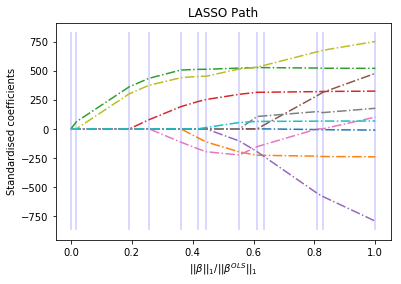

In [104]:
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html

alphas, _, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T, '-.')
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, alpha=0.2, color='blue')
plt.xlabel(r'$||\beta||_1 / ||\beta^{OLS}||_1$')
plt.ylabel('Standardised coefficients')
plt.title('LASSO Path')
plt.axis('tight')
savefig('LassoPath', dpi=500)
plt.show()

# Ridge linear regression

In [105]:
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.linear_model import Ridge

In [106]:
clf_Ridge = Ridge(alpha=1.0)
clf_Ridge.fit(X, y) 
clf_Ridge.coef_

array([  29.46574564,  -83.15488546,  306.35162706,  201.62943384,
          5.90936896,  -29.51592665, -152.04046539,  117.31171538,
        262.94499533,  111.878718  ])

In [107]:
n_alphas = 200
lambdas = np.logspace(-5, 5, n_alphas)

coefs = []
for lambda_ in lambdas:
    clf_Ridge = Ridge(alpha=lambda_)
    clf_Ridge.fit(X, y) 
    
    coefs.append(clf_Ridge.coef_)

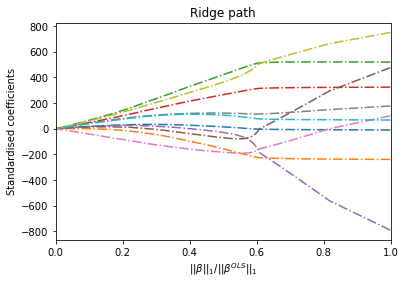

In [108]:
# #############################################################################
# Display results

ax = plt.gca()

ax.plot(np.linalg.norm(coefs, 1, axis=1)/np.linalg.norm(OLS_beta, 1), coefs, '-.')
plt.xlabel(r'$||\beta||_1 / ||\beta^{OLS}||_1$')
plt.ylabel('Standardised coefficients')
plt.title('Ridge path')
plt.axis('tight')
plt.xlim(0, 1)
savefig('RidgePath', dpi=500)
plt.show()

# Bayesian Lasso

In [109]:
def BayesianLasso(X, y, lambda_, n_iter=3000, a=0., gamma=0., 
                  standardize_X=False, standardize_Y=True):
    """
    Gibbs sampler for the Bayesian Lasso (T. Park and G. Casella, 2008)
    X : feature matrix
    y : target vector
    lambda : regularization parameter
    n_iter : number of iterations for the Gibbs sampler
    a, gamma : hyperparameters for sigma_2 InverseGamma prior
    standardize : standardizes y and X if True 
    (centering for both + scale to unit variance for X)
    """
    
    n, p = X.shape
        
    if standardize_X:
        X = scale(X)
    if standardize_Y:
        y = y - np.mean(y)
        
    
    # Initialize matrices
    beta_hist = np.zeros((n_iter, p))
    tau_2_hist = np.zeros((n_iter, p))
    tau_2_inv = np.zeros(p)
    
    # Compute Gram matrix once
    gram = np.dot(X.T, X)
    
    # Initialization
    beta = np.ones(p)
    sigma_2 = invgamma.rvs(a=0.5*(n + p - 1) + a, scale=1)
    
    for k in range(n_iter):
        # tau update
        for j in range(p):
            mean_IG = np.sqrt(sigma_2*lambda_**2/beta[j]**2)
            tau_2_inv[j] = invgauss.rvs(mu=mean_IG/lambda_**2, scale=lambda_**2)
            # /!\ scale in invgauss is not defined as scale in the article
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html
        D_tau_inv = np.diag(tau_2_inv)
                        
        # sigma update
        X_beta = np.dot(X, beta)
        shape_IG = 0.5*(n + p - 1) + a
        scale_IG = 0.5*(np.dot((y-X_beta).T, (y-X_beta)) 
                        + np.dot(beta.T, np.dot(D_tau_inv, beta))) + gamma
        sigma_2 = invgamma.rvs(a=shape_IG, scale=scale_IG)

        # beta update
        A = gram + D_tau_inv
        A_inv = np.linalg.inv(A)
        mean_mvn = np.dot(A_inv, np.dot(X.T, y))
        cov_mvn = sigma_2 * A_inv
        beta = multivariate_normal.rvs(mean=mean_mvn, cov=cov_mvn)

        # save beta and tau
        beta_hist[k, :] = beta
        tau_2_hist[k, :] = 1./tau_2_inv
        
    return beta_hist, tau_2_hist

In [110]:
lambda_= 0.23

beta_hist, tau_2_hist = BayesianLasso(X, y, lambda_, n_iter=10000)

# remove 1000 burn-in iterations
plt.plot(beta_hist[1000:,0]) # trace plot
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title(r'$\beta_1$ generated by Gibbs sampler')

# median estimate
median = np.median(beta_hist[1000:,:], axis=0)
mean = np.mean(beta_hist[1000:,:], axis=0)
print("Median estimate : {}".format(median))

KeyboardInterrupt: 

TypeError: 'function' object is not subscriptable

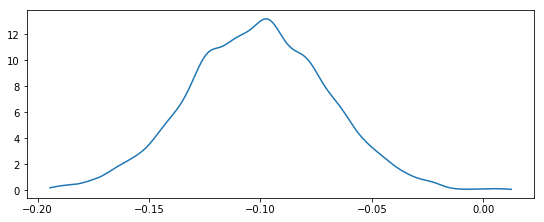

In [111]:
# Marginal posterior density function estimates (Figure 3 of the article)
plt.figure(figsize=(20,20))
var_idx = 0

for i in range(5):
    for j in range(2):
        ax = plt.subplot2grid((5,2), (i,j))
        density = gaussian_kde(beta_hist[1000:, var_idx])
        xs = np.linspace(min(beta_hist[1000:, var_idx]),max(beta_hist[1000:, var_idx]),200)
        density.covariance_factor = lambda : 0.15
        density._compute_covariance()
        ax.plot(xs,density(xs))
        ax.vlines(median[var_idx], 0, 1.2*max(density(xs)), alpha=0.9, color='red')
        ax.vlines(mean[var_idx], 0, 1.2*max(density(xs)), alpha=0.9, color='green', linestyle='dotted')
        ax.set_title(r'$\beta_{}$'.format(str(var_idx)))
        var_idx +=1
plt.tight_layout()
savefig('Posterior', dpi=500)
plt.show()

In [112]:
# Trace plot
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

In [113]:
n_lambdas = 50
lambdas = np.logspace(-2, 2, n_lambdas)

coefs = []
for lambda_ in tqdm(lambdas):
    beta_hist, _ = BayesianLasso(X, y, lambda_)
    coefs.append(np.median(beta_hist[1000:,:], axis=0))

  0%|          | 0/50 [00:00<?, ?it/s]


KeyboardInterrupt: 

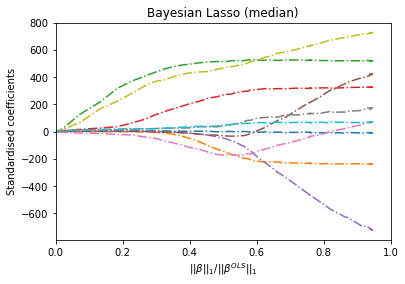

In [25]:
# #############################################################################
# Display results

ax = plt.gca()

ax.plot(np.linalg.norm(coefs, 1, axis=1)/np.linalg.norm(OLS_beta, 1), coefs, '-.')
plt.xlabel(r'$||\beta||_1 / ||\beta^{OLS}||_1$')
plt.ylabel('Standardised coefficients')
plt.title('Bayesian Lasso (median)')
plt.axis('tight')
plt.xlim(0, 1)
savefig('BayesianLassoPath', dpi=500)
plt.show()

# Choosing the Bayesian Lasso parameter

Section 5.1 of the article

In [114]:
def MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_):
    n, p = X.shape
    lambda_hist = []
    for _ in tqdm(range(n_iter_MCEM)):
        beta_hist, tau_2_hist = BayesianLasso(X, y, lambda_, n_iter=4000)
        lambda_ = np.sqrt(2*p/np.sum(np.mean(tau_2_hist[2000:], axis=0)))
        lambda_hist.append(lambda_)
    return lambda_hist

In [115]:
n_iter_MCEM = 15
lambda_hist_01 = MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_=0.1)
lambda_hist_1 = MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_=1)
lambda_hist_5 = MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_=5)
lambda_hist_10 = MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_=10)
lambda_hist_20 = MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_=20)
lambda_hist_30 = MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_=30)
lambda_hist_40 = MCEM_bayesian_lasso(n_iter_MCEM, X, y, lambda_=40)

100%|██████████| 15/15 [01:09<00:00,  4.62s/it]


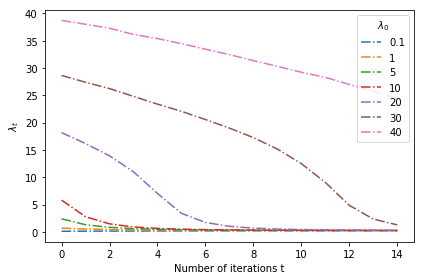

In [127]:
plt.plot(lambda_hist_01, '-.')
plt.plot(lambda_hist_1, '-.')
plt.plot(lambda_hist_5, '-.')
plt.plot(lambda_hist_10, '-.')
plt.plot(lambda_hist_20, '-.')
plt.plot(lambda_hist_30, '-.')
plt.plot(lambda_hist_40, '-.')
plt.legend(['0.1', '1', '5', '10', '20', '30', '40'], title=r'$\lambda_0$')
plt.xlabel('Number of iterations t')
plt.ylabel(r'$\lambda_t$')
plt.tight_layout()
savefig('MCEM_CV', dpi=500)

In [52]:
beta_hist, tau_2_hist = BayesianLasso(X, y, lambda_=0.235668472303, n_iter=10000)

# Grid Search for Lasso

In [49]:
# http://scikit-learn.org/stable/modules/grid_search.html
from sklearn.model_selection import GridSearchCV

In [50]:
reg_Lasso_GS = GridSearchCV(Lasso(), param_grid=dict(alpha=np.linspace(0.01, 0.2, 100)), 
                            scoring="neg_mean_squared_error", cv=n)
reg_Lasso_GS.fit(X, y)
alpha = reg_Lasso_GS.best_params_['alpha']

In [51]:
clf_Lasso = Lasso(alpha)
clf_Lasso.fit(X, y)
clf_Lasso.coef_

array([  -0.        , -193.81292314,  521.79130533,  295.10183398,
        -99.16545493,   -0.        , -222.64453348,    0.        ,
        511.87885453,   52.80918193])

# Figure 2

In [132]:
median = np.median(beta_hist[1000:,:], axis=0)
lower_error = [np.percentile(beta_hist[1000:,i], 5) for i in range(p)]
upper_error = [np.percentile(beta_hist[1000:,i], 95) for i in range(p)]

In [133]:
median

array([  -4.63148903, -213.24483753,  524.97878064,  306.8333687 ,
       -173.09177156,   -3.15941005, -149.79851704,   91.37540201,
        522.20963116,   62.23761909])

([<matplotlib.axis.YTick at 0x118543a20>,
 <a list of 10 Text yticklabel objects>)

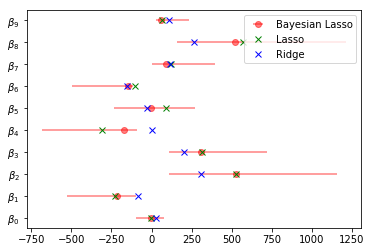

In [153]:
x = median
y = range(10)
errors = [np.abs(lower_error), np.abs(upper_error)]

plt.figure()
plt.errorbar(x, y, xerr=errors, fmt = 'o', color = 'red', alpha=0.5)
plt.errorbar(clf_Lasso.coef_, y, fmt = 'x', color = 'green')
plt.errorbar(clf_Ridge.coef_, y, fmt = 'x', color = 'blue')
plt.legend(['Bayesian Lasso', 'Lasso', 'Ridge'])
plt.yticks(range(10), [r"$\beta_{}$".format(str(i)) for i in range(10)]) 

In [104]:
errors

[array([-111.60171815, -335.61890278,  393.13049912,  178.20203961,
        -577.17753268, -280.19677392, -381.38353197, -127.32000623,
         335.07034229,  -50.40909872]),
 array([ 103.10725054,  -94.59667715,  654.42976874,  436.92346643,
         137.85476189,  338.40009669,   66.50946991,  349.72618448,
         732.05763056,  188.9902672 ])]

# Random regression problem

In [45]:
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression

from sklearn.datasets import make_regression

X_random, y_random = make_regression(500, 10, 2)

In [46]:
regr = LinearRegression()
regr.fit(X_random, y_random)
OLS_beta = regr.coef_

clf_Lasso.fit(X_random, y_random)
sum(clf_Lasso.coef_>0)

2

# Boston housing dataset

In [84]:
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html
from sklearn.datasets import load_boston
boston = load_boston()

X, y = boston.data, boston.target
n, p = X.shape

In [85]:
# OLS
regr = LinearRegression()
regr.fit(X, y)
OLS_beta = regr.coef_

# Lasso
clf_Lasso = Lasso(alpha=0.01)
clf_Lasso.fit(X, y)
Lasso_beta = clf_Lasso.coef_

# Ridge
clf_Ridge = Ridge(alpha=1.0)
clf_Ridge.fit(X, y) 
clf_Ridge.coef_

# Bayesian Lasso
beta_hist, _ = BayesianLasso(X, y, lambda_)
Bayesian_Lasso_beta = np.median(beta_hist[1000:,:], axis=0)